In [1]:
import numpy as np
from omegaconf import OmegaConf
import torch
import os

from matplotlib import pyplot as plt
from tifffile import imread

from soba_stem.pixelated_data_preprocess import PixelatedDataProcess
from soba_stem.smatrix_preprocess import SMatrixPreProcess
from soba_stem.smatrix_forward_calc import SMatrixFwdCalc
from soba_stem.optimisation import run_optimiser
from soba_stem.io_utils import *

### Import measured 4D-STEM data

4D data imported!
4D-STEM data shape: (54, 54, 40, 40)
Scan sampling: [0.21694, 0.21694]
Diff. plane sampling: [0.08536, 0.08536]


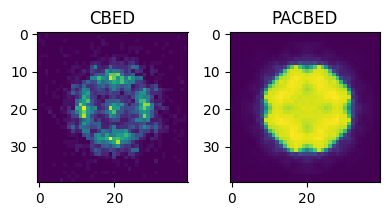

In [2]:
path_measured_config = "./multislice_frozen_phonon/measurement_config.yaml"
path_optimisation_config = "./optimisation_config.yaml"

measured_config      = OmegaConf.load(path_measured_config)
optimisation_config  = OmegaConf.load(path_optimisation_config)

measured_data          = imread(measured_config["path_4dstem_data"])
pixelated_data_process = PixelatedDataProcess(voltage=measured_config["voltage"], aperture=measured_config["aperture"])
pixelated_data_process.load_parameter(
    thickness=optimisation_config["thickness_init"],
    defocus=optimisation_config["defocus_init"],
    dry=measured_config["sampling_scanning_space"][0],
    drx=measured_config["sampling_scanning_space"][1],
    dky=measured_config["sampling_reciprocal_space"][0],
    dkx=measured_config["sampling_reciprocal_space"][1],
    rot_offset_rad=measured_config["rotation_offset_diff_plane_deg"] * np.pi / 180,
)
pixelated_data_process.cbed_import(measured_data)

measurament_params = {
    "data": pixelated_data_process.cbed_data,
    "voltage": measured_config["voltage"],
    "aperture": measured_config["aperture"],
    "sampling_scan": [pixelated_data_process.dry, pixelated_data_process.drx],
    "sampling_diff": [pixelated_data_process.dky, pixelated_data_process.dkx],
    "rot_offset_deg": measured_config["rotation_offset_diff_plane_deg"]
}

print("4D-STEM data shape:", measured_data.shape)
print("Scan sampling:", measured_config["sampling_scanning_space"])
print("Diff. plane sampling:", measured_config["sampling_reciprocal_space"])

plt.figure(figsize=(4,3))
plt.subplot(1, 2, 1)
plt.imshow(measured_data[0,0])
plt.title("CBED")
plt.subplot(1, 2, 2)
plt.imshow(np.sum(measured_data, axis=(0,1)))
plt.title("PACBED")
plt.tight_layout()
plt.show()

### Calculate an OBF image from 4D-STEM data

100.0% done...

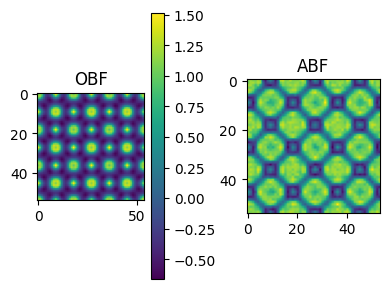

In [3]:
obf_measured_data = pixelated_data_process.OBF_pixel()
abf_measured_data = np.sum(
    pixelated_data_process.cbed_data * pixelated_data_process.D(
    ky=pixelated_data_process.kgrid[0],
    kx=pixelated_data_process.kgrid[1],
    inner=0.5,
    outer=1.0,
), axis=(2,3)
)

plt.figure(figsize=(4,3))
plt.subplot(1, 2, 1)
plt.imshow(obf_measured_data)
plt.title("OBF")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(abf_measured_data)
plt.title("ABF")
plt.tight_layout()
plt.show()

### Set beams to calculate S-matrix

number of beams:  1033


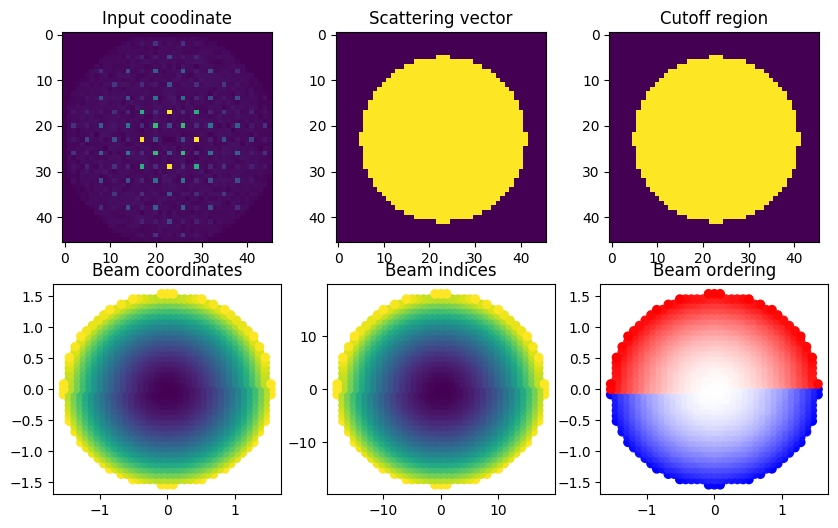

In [4]:
smatrix_preprocess = SMatrixPreProcess(
    voltage=measured_config["voltage"],
    aperture_mrad=measured_config["aperture"]
)

smatrix_preprocess.make_grid(
    ry = pixelated_data_process.ry,
    rx = pixelated_data_process.rx,
    ny = obf_measured_data.shape[0],
    nx = obf_measured_data.shape[1],
)

Ug_from_obf = np.fft.fft2(obf_measured_data/pixelated_data_process.wavelength/np.pi)\
              * smatrix_preprocess.dry*smatrix_preprocess.dry/smatrix_preprocess.ry/smatrix_preprocess.rx/optimisation_config.thickness_init

smatrix_preprocess.set_beams_from_image(image_fft=Ug_from_obf, amp_cutoff=0, show_beams=True, cutoff_k_frac=optimisation_config["beam_outer_angle"]*1.01)

### Set parameters to be optimised

In [5]:
# gpu or cpu for optimization
if torch.cuda.is_available():
    device  = torch.device('cuda')
    use_gpu = True
else:
    device = torch.device('cpu')

if optimisation_config['use_cpu']:
    device  = torch.device('cpu')
    use_gpu = False

print("Use GPU:", use_gpu)

Use GPU: True


In [6]:
smatrix_fwd_calc = SMatrixFwdCalc(
    voltage       = pixelated_data_process.voltage,
    aperture_mrad = pixelated_data_process.aperture,
    gpu_use       = use_gpu
)

smatrix_fwd_calc.make_grid(
    ry = pixelated_data_process.ry,
    rx = pixelated_data_process.rx,
    ny = Ug_from_obf.shape[0],
    nx = Ug_from_obf.shape[1],
)

smatrix_fwd_calc.import_beams(
    beam_coordinates=smatrix_preprocess.beam_coordinates,
    beam_indices=smatrix_preprocess.beam_indices
)

In [7]:
thickness_init      = torch.tensor(optimisation_config['thickness_init'], device=device, dtype=torch.float32).requires_grad_(optimisation_config['optim_thickness'])
defocus_init        = torch.tensor(optimisation_config['defocus_init'], device=device, dtype=torch.float32).requires_grad_(optimisation_config['optim_defocus'])
sourcesize_init     = torch.tensor(optimisation_config['sourcesize_init'], device=device, dtype=torch.float32).requires_grad_(optimisation_config['optim_sourcesize'])
tilt_rad_init       = torch.tensor(optimisation_config['tilt_rad_init'], device=device, dtype=torch.float32).requires_grad_(optimisation_config['optim_tilt'])
coma_init           = torch.tensor(optimisation_config['coma_init'], device=device, dtype=torch.float32).requires_grad_(optimisation_config['optim_coma'])
twofold_stig_init   = torch.tensor(optimisation_config['twofold_stig_init'], device=device, dtype=torch.float32).requires_grad_(optimisation_config['optim_twofold_stig'])
threefold_stig_init = torch.tensor(optimisation_config['threefold_stig_init'], device=device, dtype=torch.float32).requires_grad_(optimisation_config['optim_threefold_stig'])

scan_y = torch.arange(pixelated_data_process.nry, device=device, dtype=torch.float32).view(pixelated_data_process.nry, 1).expand(pixelated_data_process.nry, pixelated_data_process.nrx) / pixelated_data_process.nry * pixelated_data_process.ry
scan_x = torch.arange(pixelated_data_process.nrx, device=device, dtype=torch.float32).view(1, pixelated_data_process.nrx).expand(pixelated_data_process.nry, pixelated_data_process.nrx) / pixelated_data_process.nrx * pixelated_data_process.rx
probe_position_init = torch.stack([scan_y, scan_x], dim=-1).to(device).requires_grad_(optimisation_config['optim_probe_position'])
probe_position_original = torch.stack([scan_y, scan_x], dim=-1).to(device).clone().detach()

initial_params = {
    'potential_Ug': Ug_from_obf, #Ug_els_sc, #Ug_from_OBF * obf_offset_factor,
    'thickness': thickness_init,
    'defocus': defocus_init,
    'source_fwhm': sourcesize_init,
    'tilt_rad': tilt_rad_init,
    'coma': coma_init,
    'twofold_stig': twofold_stig_init,
    'threefold_stig': threefold_stig_init,
    'probe_position': probe_position_init,
}

### Run optimisation

In [8]:
result_optim = run_optimiser(      
    smatrix_fwd_calc=smatrix_fwd_calc,
    smatrix_preprocess=smatrix_preprocess,
    measured_data=torch.tensor(pixelated_data_process.cbed_data, device=device, dtype=torch.float32),
    initial_params=initial_params,
    data_loader_params=measurament_params,
    config=optimisation_config,
    device=device
)

Starting optimization loop...
Iteration completecutoff group 2/2: Loss = 2.2472 - 100.0% complete


### Save results

In [9]:
save_dir = path_measured_config.replace(".yaml", "_optimisation_results")
os.makedirs(save_dir, exist_ok=True)
save_dir+="/"

In [11]:
obf_image = np.fft.ifft2(result_optim['obf_initial']).real
pot_els_optimised = np.fft.ifft2(result_optim['potential_els']).real
pot_abs_optimised = np.fft.ifft2(result_optim['potential_abs']).real

save_image(obf_image, save_dir + "obf_image.tiff")
save_image(pot_els_optimised, save_dir + "potential_els_optimised.tiff")
save_image(pot_abs_optimised, save_dir + "potential_abs_optimised.tiff")

plot_params_history_main(optim_results=result_optim, save_dir=save_dir)
plot_params_history_aberrations(optim_results=result_optim, save_dir=save_dir)

save_cbed_diff(
    cbed_1=result_optim['estimated_cbed'],
    cbed_2=result_optim['measured_cbed'],
    save_dir=save_dir,
)

os.makedirs(save_dir+'params_history', exist_ok=True)
np.save(save_dir+'params_history/loss_history.npy', result_optim['loss_history'])
np.save(save_dir+'params_history/thickness_history.npy', result_optim['thickness_history'])
np.save(save_dir+'params_history/defocus_history.npy', result_optim['defocus_history'])
np.save(save_dir+'params_history/source_size_history.npy', result_optim['source_size_history'])

np.save(save_dir+'params_history/tilt_history_y.npy', result_optim['tilt_history_y'])
np.save(save_dir+'params_history/tilt_history_x.npy', result_optim['tilt_history_x'])
np.save(save_dir+'params_history/coma_history_y.npy', result_optim['coma_history_y'])
np.save(save_dir+'params_history/coma_history_x.npy', result_optim['coma_history_x'])
np.save(save_dir+'params_history/twofold_stig_history_y.npy', result_optim['twofold_stig_history_y'])
np.save(save_dir+'params_history/twofold_stig_history_x.npy', result_optim['twofold_stig_history_x'])
np.save(save_dir+'params_history/threefold_stig_history_y.npy', result_optim['threefold_stig_history_y'])
np.save(save_dir+'params_history/threefold_stig_history_x.npy', result_optim['threefold_stig_history_x'])
np.save(save_dir+'params_history/probe_position.npy', result_optim['optimised_probe_position'])